In [ ]:
#Authors: Eli Gumble, Peter Brommer, Harry Brown
#Initialisation
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import simps
from scipy import signal as sg
from scipy.interpolate import RectBivariateSpline as ReBiSpline 
from numpy import ma
#from matplotlib import colors, ticker, cm
#from random import choice
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import timeit
import math
#from PIL import Image

import matplotlib.image as image2
import itertools
from scipy import ndimage
import multiprocessing
from multiprocessing import Pool
import multiprocessedfunctions as mpf
import multiprocessedfunctions2 as mpf2
import multiprocessedfunctions6 as mpf6
import multiprocessedfunctions7 as mpf7
import multiprocessedfunctions8 as mpf8
import multiprocessedfunctions3 as mpf3
import multiprocessedfunctions3_2 as mpf3_2
from globalparameters import * # parameters below have been relocated into globalparameters.py
#from scipy import stats
#import statistics
from datetime import datetime
import time
import copy


%matplotlib inline

In [ ]:
# Read grids from image
#im = Image.open("belgiumtest.bmp")
#Base = np.array(im)

#im = image2.imread("belgiumtestorig2x.bmp")
#im = image2.imread("empty200x200grass.bmp")
im = image2.imread("empty400x400grass.bmp")

#im = image2.imread("madeleine1200x2400.bmp")
#im = image2.imread("fieldwithcrops260x400.bmp")
Base = np.array(im)

In [ ]:

#print(Base[0,0,1])
#Base = np.where(Base[:,:,0]==43, 0, Base)
#Base

#                        [[r, g, r2, g2]...]     description
landcoverlist = np.array([[22, 95, 0, 0],           # water
                          [209, 209, 150, 150],       # bare floor
                          [139, 139, 175, 175],     # artificial surface
                          [221, 5, 0, 0],           # building
                          [255, 255, 0, 200],            # herbaceous cover in rotation throughout year
                          [234, 255, 70, 200],       # herbaceous cover (grass)
                          [40, 202, 40, 200],        # tall hardwood > 3m
                          [185, 233, 30, 200],       # short hardwood < 3m
                          [1, 47, 65, 200],          # tall softwood > 3m
                          #[0, 0, 0, 0],            # short softwood < 3m
                          [43, 80, 0, 0]])          # boundary
                                        
#len(landcoverlist)

for k in range (len(landcoverlist)):
    for i in range(len(Base)):             #vertical pixels
        for j in range(len(Base[0])):      #horizontal pixels
            if Base[i][j][0] == landcoverlist[k,0] and Base[i][j][1] == landcoverlist[k,1]:
                Base[i][j] = [landcoverlist[k,2],landcoverlist[k,3],0,255]


In [ ]:
Base[:,:,2] = 0 #set all pixel B values to 0

Base[:,:,3] = 255 #set all of the 4th rgb element to 255 because things might break otherwise

In [ ]:
# Define internal quantities and variables
scale = 1./4. #m per pixel
Nx = Base[:,0,0].size #N appears to be resolution
Ny = Base[0,:,0].size
xmin=-scale*0.5*(Nx-1)
xmax=scale*0.5*(Nx-1)
ymin=-scale*0.5*(Ny-1)
ymax=scale*0.5*(Ny-1)
x = np.linspace(xmin, xmax, Nx) # This is defining the axes and full space
y = np.linspace(ymin, ymax, Ny)
Y, X= np.meshgrid(y, x)
TrailPotential = np.zeros((Nx,Ny))
DestinationPotential=np.zeros((Nx,Ny))
Weight=np.zeros((Nx,Ny))  # Create gradient to sit on Nx, Ny
intens=np.zeros((Nx,Ny))
q_alpha=np.zeros((Nx,Ny))
expdist=np.zeros((2*Nx-1,2*Ny-1))
dest=np.zeros((2))
start=np.zeros((2))
grad=np.zeros((2,Nx,Ny))
vel=np.asarray([0.,0.])
pos=np.asarray([0.,0.])
stalledpos = [] # empty container for stalled positions of walkers
stalledposrounded = []

intens[:]=0.
isigma=0.15 # functions as 'smoothing intensity' of trail potentials, value < 0.5 leads to more smoothing, can cause more path merging and fewer straight lines
#t._track=25. # Track decay time - after 50 walkers ignore a trail, it decays by 1/e
wlkr_range = 10000
#print(route)
'''
#parameters
dt=0.1  # dt per time step, continuous markings every dt metres
dvel=1. # desired walker velocity in m/s
tau=5.
isigma=0.5 # trail potential
trailpotweight = 0.004 # weighting of trail potential over destination potential, started as 0.003, increasing this increases number of stalls
storedtrailpotweight = trailpotweight
conv_thresh=10.e-4
precision=1.**2 #distance to target.
eps=0.025 #random motion contribution, same for all
'''

In [ ]:
##Set up map
#Create blank arrays for map 
z = np.zeros((Nx,Ny))
g_max=np.zeros((Nx,Ny))
g_nat=np.zeros((Nx,Ny))

g_nat=np.maximum(np.ones_like(g_nat),np.float64(Base[:,:,0]))
g_max=np.maximum(np.ones_like(g_max),np.float64(Base[:,:,1]))
z=g_nat

track_labels=Base[:,:,2]

numpoints=np.max(track_labels)

point=np.zeros((numpoints,2))

for i in range(0,Nx):
    for j in range(0,Ny):
        if (track_labels[i,j]>0):
            point[track_labels[i,j]-1]=np.array([i,j])
print (point)

# Trails (start and end point) For current Map, coordinates in metres, centre of image = (0,0)

# single possible path
# route=np.array([[24.,-9.75],[-24.,9.75]]),


In [ ]:

# big field with tennis court parking lot and hospital, near rue cottrel
ptA = [-40.,-240.]      # tennis court near middle
ptB = [-250.,-200.]     # tennis court near skatepark
#ptC = [-350., 25.]     # parking lot entrance >>>>>>>>>>>>> removed because its very close to ptD, won't give interesting information, not worth computational work
ptD = [-350., 80.]      # parking lot bus stop
ptE = [-70., 230.]      # east road pedestrian entrance
ptF = [200., 200.]      # hospital bus stop
ptG = [250., 100.]      # hospital side path
ptH = [350., -100.]     # dirt car park
ptI = [210., -140.]     # west side entrance

#listofdestinations = [ptA,ptB,ptD,ptE,ptF,ptG,ptH,ptI,ptA,ptB,ptD,ptE,ptF,ptG,ptH,ptI] # list is repeated so that the combinations function below generates not only AB but BA
listofdestinations = [[0,25],[-10,-25],[10,-25],[0,25],[-10,-25],[10,-25],] #steiner points 200x200
#listofdestinations = [[0,10],[-5,-10],[5,-10],[0,10],[-5,-10],[5,-10]] #steiner points 200x200 (small scale)

#listofdestinations = [[150,25],[-165,45]] # fieldwithcrops
#listofdestinations = [[-165,45],[150,25],[0,-85],[-165,45],[150,25],[0,-85]] # fieldwithcrops
# listofdestinations = [[0,-85],[-165,45],[150,25],[0,-85],[-165,45],[150,25]]
#listofdestinations = [[0,-85],[150,25],[-165,45],[0,-85],[150,25],[-165,45]]

#listofdestinations = [[40,20],[-40,20],[40,-20],[-40,-20],[40,20],[-40,20],[40,-20],[-40,-20]] # criss cross thing

#listofdestinations = [[-375, -160], [-330, -50], [210, 110], [300, 20], [340, -80], [390, -150]] #madeleine
#listofdestinations = [[-25,-25],[25,25]]
route = []

#       should probably turn all of this into a function

# generate route combinations
for i in itertools.combinations(listofdestinations, 2):
    route.append(i)

# remove duplicate routes https://stackoverflow.com/questions/2213923/removing-duplicates-from-a-list-of-lists
routetemp = []
for i in route:
    if i not in routetemp:
        routetemp.append(i)
route = routetemp

# delete AA, BB, CC routes
zzzzz = -1
for row in route:
    zzzzz+=1
    if row[0] == row[1]:
        route.pop(zzzzz)

routearray = np.empty((len(route),2,2))

# convert list of lists to 3d array
for k in range(len(route)):
    for i in range(2):
        for j in range(2):
            routearray[k][i][j] = route[k][i][j]

route = routearray # convert routearray back to variable name understood by code
#route = [[[0,100],[-25,0]],[[0,100],[25,0]]]

#route = np.array([[[-30, 20],[0,40]],[[-30,-20],[0,-20]],[[0,20],[-30, 20]],[[0,-20],[-30,-20]]])

t_track=4*0.5*float(len(route)) # Track decay time - after 50 walkers ignore a trail, it decays by 1/e

In [ ]:
#for i in listofdestinations
#    route[i,0:len(listofdestinations)] = listofdestinations[i]

# small field by apartment with 4 entrances 
#posA = [-5., -17.]
#posB = [-25., -17.]
#posC = [-25., 8.]
#posD = [40., 10.]

# acceptable routes = A/B to C, A/C to D and vice versa, 8 total routes
#route=np.array([[posA,posC],
#                 [posB,posC],
#                 [posC,posA],
#                 [posC,posD],
#                 [posA,posC],
#                 [posC,posD],
#                 [posD,posA],
#                 [posD,posC],
#                 ])


In [ ]:
#Setup weight matrix, here trapezoid rule.
Weight[:,:]=1
Weight[1:-1,:]=2
Weight[:,1:-1]=2
Weight[1:-1,1:-1]=4
Weight*=0.25*((x[-1]-x[0])/(Nx-1))*((y[-1]-y[0])/(Ny-1))
#0.25*((x[-1]-x[0])/(N-1))*((y[-1]-y[0])/(N-1))
#np.exp(-np.sqrt((x[:,None]-x[N/2])**2+(y[None,:]-y[N/2])**2))*z[:,:]

In [ ]:
# Setup distance matrix
for xi in range(1,Nx+1):
    for yi in range(1,Ny+1):
        
        expdist[xi-1,yi-1]=np.exp(-isigma*np.sqrt((x[Nx-xi]-xmin)**2+(y[Ny-yi]-ymin)**2))
        expdist[-xi,-yi]  = expdist[xi-1,yi-1]
        expdist[-xi,yi-1] = expdist[xi-1,yi-1]
        expdist[xi-1,-yi] = expdist[xi-1,yi-1]
        
# find index range > conv_thresh
subexpdist=expdist[(expdist>conv_thresh).any(1)]
subexpdist=subexpdist[:, np.any(subexpdist>conv_thresh, axis=0)]
#subexpdist=subexpdist[:,np.any(subexpdist>conv_thresh, axis=0)]
#expdist[subexpdist]=0.
subexpdist.shape
#expdist
#subexpdist


In [ ]:
def calc_tr_new():
    TrailPotential[:,:]=sg.convolve2d(z[:,:]*Weight[:,:],subexpdist[:,:],mode="same")  # 2D convolution

In [ ]:
len(TrailPotential)

In [ ]:
def calc_tr_gauss():
    TrailPotential[:,:]=ndimage.gaussian_filter(z[:,:], 1, 0) #,TrailPotential,mode='nearest')

In [ ]:
#Integrate z, trapezoid rule eq 20
#def calc_tr():
#    global xi,yi,tr,expdist,z,wght,Nx,Ny
#    for xi in range(0,Nx): 
#        for yi in range(0,Ny):
#            tr[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*wght[:,:])

In [63]:
timeit.timeit(calc_tr_new,number=1)

30.988411999999926

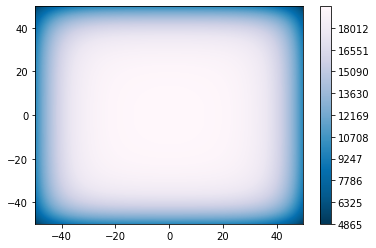

In [64]:
# Defines a Plot to show the smoothing of the supplied map to represent the respective potentials of the ground, the larger
# the potentials, the more attractive the ground is to the walker

cs = plt.contourf(X, Y, TrailPotential, levels=np.linspace(TrailPotential.min(),TrailPotential.max(),1000),cmap='PuBu_r')
cbar = plt.colorbar()

plt.show()
#plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])

In [65]:
#set up walker
def set_up_walker(route_id):
    global vel, pos, track, dest, start, route
    #start
    dispersion = 5 # length away from start point walkers are allowed to spawn, measured in m

    start = np.array(route[route_id, 0, :]) # commented for simplicity
    start[0] += np.random.randint(-dispersion, dispersion+1) # adds dispersion to x
    start[1] += np.random.randint(-dispersion, dispersion+1) # adds dispersion to y
    # start = np.array([24.,-9.75])  # temporary one route
    # dest = np.array([-24.,9.75])  # temporary one route
    # dest=(random.choice(ends))
    dest = np.array(route[route_id, 1, :]) # commented for simplicity
    dest[0] += np.random.randint(-dispersion, dispersion+1)
    dest[1] += np.random.randint(-dispersion, dispersion+1)
    vel = np.array([0., 0.])
    pos = np.array(start)
    #print (pos)
    track = np.zeros((wlkr_range, 2))
    #track[0,:]=pos[:]

In [66]:
#Calculate gradients eq 19
#Trail gradient
def setup_potentials():
    global grad,desdirx,desdiry,dest,trailpotweight
    grad=np.zeros((2,Nx,Ny))
    grad=trailpotweight*np.array(np.gradient(TrailPotential))
    #grad=0.002*np.array(np.gradient(TrailPotential)) ORIGINAL
    
    #print (dest)
    #Destination potential
    DestinationPotential=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    #Combine gradients
    grad+=np.array(np.gradient(DestinationPotential)[:])
    #Normalise
    #grad[:,:,:]/=(np.sqrt(grad[0,:,:]**2+grad[1,:,:]**2))
    desdirx=ReBiSpline(x,y,grad[0,:,:],s=2) # gradeint plus magnitude, Spline approximation over a rectangular mesh
    desdiry=ReBiSpline(x,y,grad[1,:,:],s=2) 
    #plot()
    #print(grad)

In [67]:
# #Plot the direction
# scgrad=np.arctan2(grad[1],grad[0])
# levels = np.linspace(-np.pi, np.pi, 360)
# cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

# cbar = plt.colorbar()
# # ERROR # plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])
# #plt.scatter(start, dest)
# print(start)
# print(dest)
# plt.show()

In [68]:
# This function rounds a point, and checks if it is already in the list of rounded points
# If its already in the list it, it increases the count value for that point by 1
# If its not in the list, it adds it to the list with a count of 1

def stalledposregioncounter(newpos,stalledposrounded2):
    nearest = 5
    newposxrounded = round(newpos[0]/nearest)*nearest # round x
    newposyrounded = round(newpos[1]/nearest)*nearest # round y

    newposrounded = {"x":newposxrounded,"y":newposyrounded,"count":1}
    
    for i in stalledposrounded2:
        if i["x"] == newposrounded["x"] and i["y"] == newposrounded["y"]:
            i["count"]+=1
            return stalledposrounded2
    stalledposrounded2.append(newposrounded)
    return stalledposrounded2

In [69]:
def calc_path():
    global pos,vel,intens,track,dest,dvel,tau,stalledpos,stalledposrounded,trailpotweight,storedtrailpotweight
    
    i=0
    hist=10
    samp=10
    avpos=np.zeros((2,hist))
    internalclock = 0 # not measured in seconds, probably measured in 'dt's
    stallcounter = 0
    trailpotweight = 0.004 # weighting of trail potential over destination potential, started as 0.003, increasing this increases number of stalls
    storedtrailpotweight = trailpotweight

    # https://www.programiz.com/python-programming/datetime/current-time
    #now = datetime.now()
    #current_time = now.strftime("%H:%M:%S")
    #print("Calc path entered, time =", current_time)

    #Setup While loop to run until either the walker reaches the destination or the walker has passed 'wlkr_range' number of movement cycles to 
    #attempt to get there
    while (np.dot(pos-dest,pos-dest)>precision and i<wlkr_range):
    #set the postiion of the walker on its first then subsequent cycles
        
        #conditional logic saying to update the average position of the walker every 10 iterations
        #if (i%samp==0): avpos[:,(i%hist)//samp]=pos[:] #ORIGINAL
        if (i%samp==0): avpos[:,(i%(hist*samp))//samp]=pos[:]
            
        #print((i%hist)//samp)
        #print(avpos)
        
        gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
        xi=np.array(np.random.normal(0,1,2))
        # Equation 6 in Helbing, differential in position, eliminised velocity decay components
        # gradmagnitude makes sure it is normalised, desdir not normalised
        pos[0]+= dt *(dvel * desdirx(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[0])  # x-position vector component 
        pos[1]+= dt *(dvel * desdiry(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[1])  # y-position vector component
        
        internalclock+=1
        if internalclock == 250 and trailpotweight != storedtrailpotweight:
                trailpotweight = storedtrailpotweight
                #print(trailpotweight)
                setup_potentials() # recalculate potentials
        
#        posGrad = math.degree(math.atan(pos[0]/pos[1]) # future position
        curDir = math.atan(desdiry(pos[0],pos[1])/desdirx(pos[0],pos[1]))
#         print(posGrad)
        # print(curDir)
        # pos+=dt*vel
        
        #vel[0]+=-1/tau*vel[0] + (dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]   # Eqiation 5 in Helbing, differential in velocity
        #vel[1]+=-1/tau*vel[1] + (dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]
        
        #Set the current position of the walker into the trakc array for the current iteration
        track[i,:]=pos[:]

#        if math.isnan(pos[1])==1: 
#                print ("NaN error ",pos,vel, dest)
#                break

        intens[int((pos[0]-xmin)*(Nx-1)/(xmax-xmin)),int((pos[1]-ymin)*(Ny-1)/(ymax-ymin))]+=1.
        i+=1
        if (i%(hist*samp)==0):
            meanpos=np.mean(avpos,axis=1)
            if (np.dot(pos-meanpos,pos-meanpos)<precision): 
                #print ("Stalled progress ",pos,meanpos,vel, dest)
                #stalledpos.append(meanpos) # store positions where walkers are stalled
                #stalledposrounded = stalledposregioncounter(meanpos, stalledposrounded) # store ROUNDED positions of walker stalls and count occurence in rounded position
                trailpotweight = 0.002 # reduce tpotweight to favour destination more
                #print(trailpotweight)
                setup_potentials() # recalculate the trail potentials with lower weight
                internalclock = 0 # reset clock
                stallcounter+=1 # take notice of the fact that there was a stall
                #break
        if stallcounter == 3: # 3 represents the number of stalls before stopping the walker, this will happen with hard obstacles like buildings and water
                print ("Stalled progress ",pos,meanpos, dest)
                stalledpos.append(meanpos) # store positions where walkers are stalled
                stalledposrounded = stalledposregioncounter(meanpos, stalledposrounded) # store ROUNDED positions of walker stalls and count occurence in rounded position
                break
    if (i==wlkr_range): print ("Missed goal ",dest,pos)           
    return i    
#stopping condition   

In [70]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground_old():
    global q_alpha,intens,z,g_max,t_track,g_nat
    q_alpha=intens*(1.-z/g_max)
    # Time evolution of ground potential
    #zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha
    #cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
    #cbar = plt.colorbar()
    #plt.show
    #z[140:160,45:75]

In [71]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground():
    global q_alpha,intens,z,g_max,t_track,g_nat,Nx,Ny

    for zj in range(Nx):
        for zi in range(Ny):
            if z[zj][zi] > g_max[zj][zi]: z[zj][zi] = g_max[zj][zi]
            if z[zj][zi] < g_nat[zj][zi]: z[zj][zi] = g_nat[zj][zi]

    q_alpha=intens*(1.-z/g_max)
    # Time evolution of ground potential
    #zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha

    for zj in range(Nx):
        for zi in range(Ny):
            if z[zj][zi] > g_max[zj][zi]: z[zj][zi] = g_max[zj][zi]
            if z[zj][zi] < g_nat[zj][zi]: z[zj][zi] = g_nat[zj][zi]

    #cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
    #cbar = plt.colorbar()
    #plt.show
    #z[140:160,45:75]

In [72]:
def plot_path():
    plt.contourf(X, Y, z, levels=np.linspace(0,z.max(),1000),cmap='PuBu_r')
    plt.colorbar()
    plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1,np.array([[0,1,0]]))
    plt.show(block=False)

In [73]:
def plot_path_intens():
    plt.contourf(X, Y, intens, levels=np.linspace(0,z.max(),1000),cmap='PuBu_r')
    plt.colorbar()
    #plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1,np.array([[0,1,0]]))
    plt.show(block=False)

In [74]:
def plot_path2():
    global stalledpos
    markercolour = np.array([[1,0,0]])

    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    
    stalledposarray = np.array(stalledpos)
    plt.scatter(stalledposarray[0:-1,0],stalledposarray[0:-1,1],1.,markercolour)
    plt.show(block=False)

In [75]:
def plot_path3():
    global stalledposrounded
    stalledposrounded3 = []

    markercolour = np.array([[1,0,0]])
    
    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    
    for i in stalledposrounded:
        stalledposrounded3.append([i["x"],i["y"]])

    stalledposarray2 = np.array(stalledposrounded3)
    plt.scatter(stalledposarray2[0:-1,0],stalledposarray2[0:-1,1],1.,markercolour)
    plt.show(block=False)

In [76]:
multiprocessing.cpu_count()

12

In [77]:
def detect_local_maxima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max ^ eroded_background
    return np.where(detected_maxima) 

In [78]:
def plot_potentials():
    global dest
    TotPot = np.zeros((Nx,Ny))
    TotPot =- np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    TotPot += 0.003*TrailPotential
    maxima=detect_local_maxima(TotPot)
    cs = plt.contourf(X, Y, TotPot, levels=np.linspace(TotPot.min(),TotPot.max(),1000),cmap='PuBu_r')
    cbar = plt.colorbar()
    print(maxima)
    plt.scatter(x[maxima[0]],y[maxima[1]])
    plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1)
    plt.show
    # commit test

In [79]:
tau = 5

In [80]:
#rowval = np.empty((1,Ny))

0.0
31.058421299999964  = Time taken for calc_tr
0.4790407000000414  = Time taken for iteration  0
0 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.82646428 -24.06955858] Time of completion: 18:55:02 Time taken:  0.17
0 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.79417793 -24.05105426] Time of completion: 18:55:02 Time taken:  0.17
0 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.40122176 -24.29516511] Time of completion: 18:55:02 Time taken:  0.17
0 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.11900216 24.06234275] Time of completion: 18:55:02 Time taken:  0.17
0 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.0293439  24.02282468] Time of completion: 18:55:02 Time taken:  0.16
0 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.34576094 -24.25025982] Time of completion: 18:55:02 Time taken:  0.14
0.1867730000001302  = Time taken for update_ground 
2.684245593355648
31.057924400000

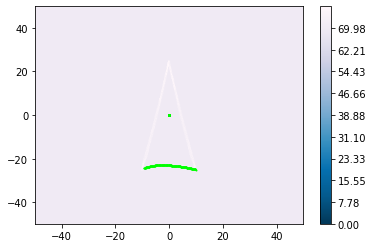

2.663245605847422
31.006713399999853  = Time taken for calc_tr
0.4651082000000315  = Time taken for iteration  2
2 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.75521239 -24.08860482] Time of completion: 18:56:07 Time taken:  0.18
2 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.73975134 -24.06649397] Time of completion: 18:56:07 Time taken:  0.17
2 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.35205758 -24.28266634] Time of completion: 18:56:07 Time taken:  0.16
2 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.16120921 24.10087449] Time of completion: 18:56:07 Time taken:  0.17
2 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.0261799  24.05416193] Time of completion: 18:56:07 Time taken:  0.18
2 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.4400793  -24.29378343] Time of completion: 18:56:07 Time taken:  0.14
0.18234460000007857  = Time taken for update_ground 


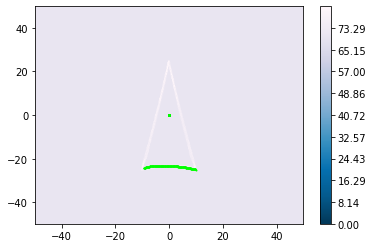

2.6174650605211442
31.044136099999832  = Time taken for calc_tr
0.48640069999987645  = Time taken for iteration  3
3 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.78897204 -24.05596418] Time of completion: 18:56:41 Time taken:  0.18
3 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.74161711 -24.04919297] Time of completion: 18:56:41 Time taken:  0.17
3 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.38231    -24.22853512] Time of completion: 18:56:41 Time taken:  0.17
3 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.12119508 24.08385997] Time of completion: 18:56:41 Time taken:  0.19
3 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.03983259 24.02695826] Time of completion: 18:56:41 Time taken:  0.17
3 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.34104799 -24.2700779 ] Time of completion: 18:56:41 Time taken:  0.18
0.18120669999984784  = Time taken for update_ground 


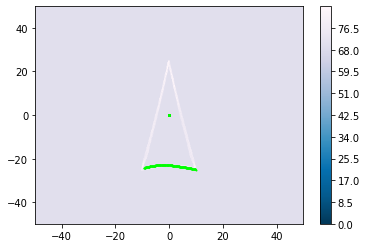

2.59008356061871
31.020379100000127  = Time taken for calc_tr
0.4719420999999784  = Time taken for iteration  4
4 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.75613619 -24.0604638 ] Time of completion: 18:57:15 Time taken:  0.16
4 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.77023675 -24.07517995] Time of completion: 18:57:15 Time taken:  0.17
4 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.38640154 -24.27790975] Time of completion: 18:57:15 Time taken:  0.14
4 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.15586285 24.09978295] Time of completion: 18:57:15 Time taken:  0.17
4 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.072281  24.0737207] Time of completion: 18:57:15 Time taken:  0.17
4 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.39133697 -24.22068919] Time of completion: 18:57:15 Time taken:  0.15
0.18012210000006235  = Time taken for update_ground 


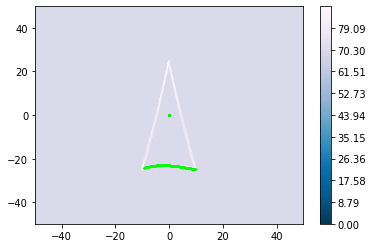

2.5641856196749786
31.028913300000113  = Time taken for calc_tr
0.46056369999996605  = Time taken for iteration  5
5 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.75271945 -24.11791894] Time of completion: 18:57:48 Time taken:  0.19
5 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.75553051 -24.11602679] Time of completion: 18:57:48 Time taken:  0.18
5 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.37518823 -24.31278748] Time of completion: 18:57:48 Time taken:  0.16
5 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.13346093 24.03727689] Time of completion: 18:57:48 Time taken:  0.15
5 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.07407519 24.00467494] Time of completion: 18:57:48 Time taken:  0.16
5 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.37096066 -24.25092485] Time of completion: 18:57:48 Time taken:  0.16
0.17964610000012726  = Time taken for update_ground 


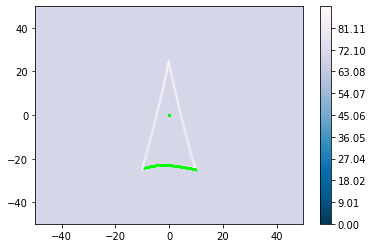

2.5680022276540626
31.03916120000008  = Time taken for calc_tr
0.48292670000000726  = Time taken for iteration  6
6 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.76507311 -24.10628198] Time of completion: 18:58:22 Time taken:  0.19
6 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.76138445 -24.12359139] Time of completion: 18:58:22 Time taken:  0.17
6 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.42127402 -24.19187976] Time of completion: 18:58:22 Time taken:  0.16
6 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.11545109 24.05986718] Time of completion: 18:58:22 Time taken:  0.17
6 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.05112766 24.03557166] Time of completion: 18:58:22 Time taken:  0.17
6 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.38611691 -24.22679378] Time of completion: 18:58:22 Time taken:  0.16
0.18233039999995526  = Time taken for update_ground 


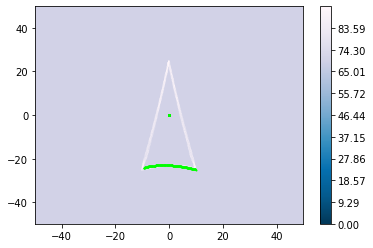

2.5086562889292936
31.029290500000116  = Time taken for calc_tr
0.4582676999998512  = Time taken for iteration  7
7 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.75553888 -24.07935823] Time of completion: 18:58:56 Time taken:  0.16
7 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.79234833 -24.10919526] Time of completion: 18:58:56 Time taken:  0.16
7 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.3700174  -24.28172938] Time of completion: 18:58:56 Time taken:  0.16
7 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.12587724 24.09653944] Time of completion: 18:58:56 Time taken:  0.17
7 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.07418046 24.03004065] Time of completion: 18:58:56 Time taken:  0.18
7 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.35745602 -24.2514242 ] Time of completion: 18:58:56 Time taken:  0.14
0.1896219000000201  = Time taken for update_ground 


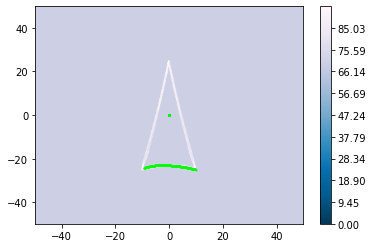

2.500904944744275
31.082407299999886  = Time taken for calc_tr
0.45768679999991946  = Time taken for iteration  8
8 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.77017778 -24.06814328] Time of completion: 18:59:30 Time taken:  0.16
8 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.80795765 -24.03432373] Time of completion: 18:59:30 Time taken:  0.16
8 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.42840284 -24.18566874] Time of completion: 18:59:30 Time taken:  0.15
8 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.07308629 24.05446686] Time of completion: 18:59:30 Time taken:  0.16
8 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.06547827 24.08845841] Time of completion: 18:59:30 Time taken:  0.17
8 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.44197363 -24.20563317] Time of completion: 18:59:30 Time taken:  0.14
0.18084129999988363  = Time taken for update_ground 


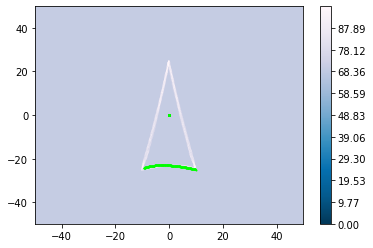

2.4998811211765957
31.050365900000088  = Time taken for calc_tr
0.4657167999998819  = Time taken for iteration  9
9 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.80727276 -24.09913928] Time of completion: 19:00:04 Time taken:  0.16
9 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.7968399  -24.08599823] Time of completion: 19:00:04 Time taken:  0.17
9 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.41934404 -24.22438625] Time of completion: 19:00:04 Time taken:  0.18
9 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.10240968 24.02673326] Time of completion: 19:00:04 Time taken:  0.17
9 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.05724595 24.00447746] Time of completion: 19:00:04 Time taken:  0.17
9 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.45303736 -24.215688  ] Time of completion: 19:00:04 Time taken:  0.15
0.18233180000015636  = Time taken for update_ground 


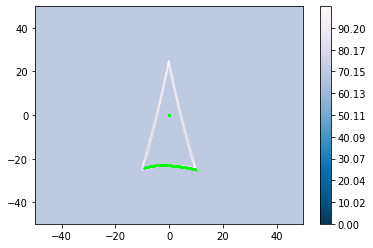

2.4966633276736374
31.26712170000019  = Time taken for calc_tr
0.48246789999984685  = Time taken for iteration  10
10 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.86028329 -24.0862245 ] Time of completion: 19:00:38 Time taken:  0.17
10 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.83034055 -24.06975875] Time of completion: 19:00:38 Time taken:  0.15
10 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.49849697 -24.19373578] Time of completion: 19:00:38 Time taken:  0.17
10 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.09099613 24.02511665] Time of completion: 19:00:38 Time taken:  0.17
10 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.05238068 24.06460792] Time of completion: 19:00:38 Time taken:  0.17
10 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.48164115 -24.2391599 ] Time of completion: 19:00:38 Time taken:  0.14
0.18264339999996082  = Time taken for update_ground 


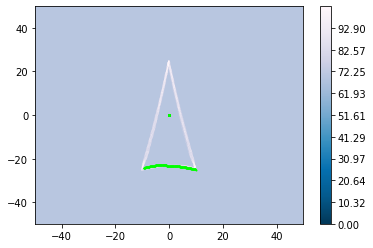

2.464019460415819
31.455006599999933  = Time taken for calc_tr
0.466777699999966  = Time taken for iteration  11
11 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.71723689 -24.08766726] Time of completion: 19:01:12 Time taken:  0.17
11 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.87374747 -24.09503864] Time of completion: 19:01:12 Time taken:  0.17
11 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.51934128 -24.21338817] Time of completion: 19:01:12 Time taken:  0.15
11 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.13894799 24.02803731] Time of completion: 19:01:12 Time taken:  0.17
11 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.10949199 24.08013236] Time of completion: 19:01:12 Time taken:  0.17
11 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.48974392 -24.20150715] Time of completion: 19:01:12 Time taken:  0.16
0.183837899999844  = Time taken for update_ground 


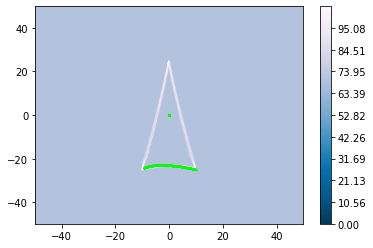

2.4635745115939773
31.424365800000032  = Time taken for calc_tr
0.46023429999991095  = Time taken for iteration  12
12 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.74753895 -24.03464386] Time of completion: 19:01:46 Time taken:  0.14
12 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.67470487 -24.10962521] Time of completion: 19:01:46 Time taken:  0.16
12 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.48139595 -24.2304425 ] Time of completion: 19:01:46 Time taken:  0.17
12 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.08213887 24.08377952] Time of completion: 19:01:46 Time taken:  0.19
12 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.08753474 24.02948941] Time of completion: 19:01:46 Time taken:  0.16
12 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.44319247 -24.19717281] Time of completion: 19:01:46 Time taken:  0.14
0.18543940000017756  = Time taken for update_ground 


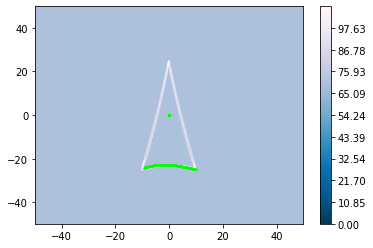

2.456976039432602
32.14934519999997  = Time taken for calc_tr
0.5207766000000902  = Time taken for iteration  13
13 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.743853   -24.13517546] Time of completion: 19:02:21 Time taken:  0.21
13 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.76716539 -24.13492542] Time of completion: 19:02:21 Time taken:  0.19
13 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.48805002 -24.19308378] Time of completion: 19:02:21 Time taken:  0.19
13 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.11123199 24.00881143] Time of completion: 19:02:21 Time taken:  0.20
13 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.07423584 24.0598825 ] Time of completion: 19:02:21 Time taken:  0.20
13 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.48981739 -24.22031663] Time of completion: 19:02:21 Time taken:  0.17
0.19604099999992286  = Time taken for update_ground 


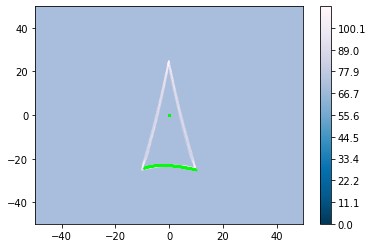

2.4503205829290398
31.57565560000012  = Time taken for calc_tr
0.4708149999999023  = Time taken for iteration  14
14 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.76756677 -24.11576466] Time of completion: 19:02:56 Time taken:  0.18
14 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.75148665 -24.0405161 ] Time of completion: 19:02:56 Time taken:  0.17
14 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.52736044 -24.22172629] Time of completion: 19:02:56 Time taken:  0.13
14 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.12494602 24.03542016] Time of completion: 19:02:56 Time taken:  0.18
14 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.07450671 24.03104714] Time of completion: 19:02:56 Time taken:  0.18
14 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.51386425 -24.20234512] Time of completion: 19:02:56 Time taken:  0.13
0.19394720000013876  = Time taken for update_ground 


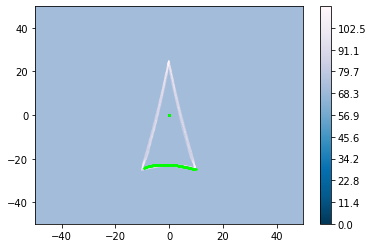

2.434189610277889
31.486504300000206  = Time taken for calc_tr
0.47749819999989995  = Time taken for iteration  15
15 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.77037709 -24.12025557] Time of completion: 19:03:30 Time taken:  0.15
15 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.77223632 -24.030107  ] Time of completion: 19:03:30 Time taken:  0.15
15 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.51873164 -24.19003385] Time of completion: 19:03:30 Time taken:  0.14
15 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.12144352 24.06519631] Time of completion: 19:03:30 Time taken:  0.19
15 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.05731009 24.05374535] Time of completion: 19:03:30 Time taken:  0.19
15 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.42581058 -24.19753804] Time of completion: 19:03:30 Time taken:  0.12
0.18967829999996866  = Time taken for update_ground 


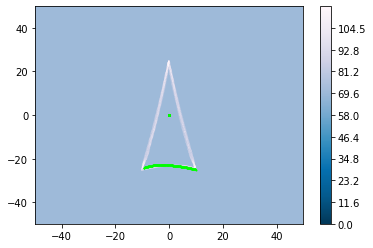

2.39075447522029
31.58475959999987  = Time taken for calc_tr
0.48665410000012344  = Time taken for iteration  16
16 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.72558244 -24.03968408] Time of completion: 19:04:04 Time taken:  0.20
16 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.81362915 -24.07888389] Time of completion: 19:04:04 Time taken:  0.16
16 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.44630539 -24.16831336] Time of completion: 19:04:04 Time taken:  0.15
16 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.13326402 24.01741913] Time of completion: 19:04:04 Time taken:  0.17
16 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.05436524 24.08026212] Time of completion: 19:04:04 Time taken:  0.20
16 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.5303709  -24.17360061] Time of completion: 19:04:04 Time taken:  0.13
0.19191649999993388  = Time taken for update_ground 


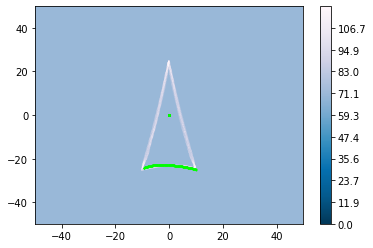

2.380029969584775
31.471432899999854  = Time taken for calc_tr
0.5117139999999836  = Time taken for iteration  17
17 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.76392961 -24.03996708] Time of completion: 19:04:38 Time taken:  0.16
17 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.82013291 -24.01649489] Time of completion: 19:04:38 Time taken:  0.15
17 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.61747582 -24.16965781] Time of completion: 19:04:38 Time taken:  0.16
17 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.0996519  24.03347204] Time of completion: 19:04:38 Time taken:  0.16
17 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.07870875 24.00557979] Time of completion: 19:04:39 Time taken:  0.19
17 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.47973196 -24.1550499 ] Time of completion: 19:04:39 Time taken:  0.17
0.19010809999986122  = Time taken for update_ground 


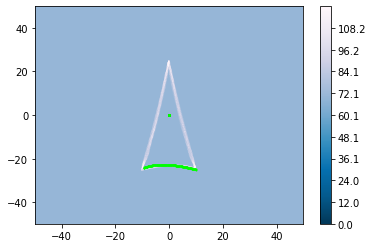

2.420863061000704
31.715588399999888  = Time taken for calc_tr
0.4525066000001061  = Time taken for iteration  18
18 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.72345877 -24.13238314] Time of completion: 19:05:13 Time taken:  0.17
18 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.82275594 -24.06242737] Time of completion: 19:05:13 Time taken:  0.17
18 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.56205727 -24.14863986] Time of completion: 19:05:13 Time taken:  0.17
18 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.09823884 24.0705984 ] Time of completion: 19:05:13 Time taken:  0.15
18 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.10175011 24.10245997] Time of completion: 19:05:13 Time taken:  0.15
18 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.47943284 -24.14999361] Time of completion: 19:05:13 Time taken:  0.17
0.18614430000002358  = Time taken for update_ground 


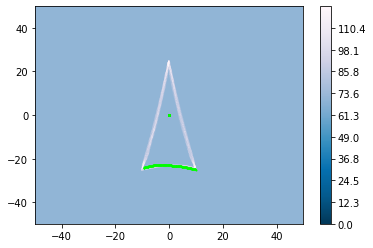

2.3626229684888354
31.462865299999976  = Time taken for calc_tr
0.4570028000000548  = Time taken for iteration  19
19 Reached Goal |  Start:  [ 0. 25.] Dest:  [-10. -25.] Pos:  [ -9.77387977 -24.03237088] Time of completion: 19:05:47 Time taken:  0.17
19 Reached Goal |  Start:  [ 0. 25.] Dest:  [ 10. -25.] Pos:  [  9.65211692 -24.10017281] Time of completion: 19:05:47 Time taken:  0.17
19 Reached Goal |  Start:  [-10. -25.] Dest:  [ 10. -25.] Pos:  [  9.50014979 -24.19627988] Time of completion: 19:05:47 Time taken:  0.15
19 Reached Goal |  Start:  [-10. -25.] Dest:  [ 0. 25.] Pos:  [-0.11168356 24.09606248] Time of completion: 19:05:47 Time taken:  0.15
19 Reached Goal |  Start:  [ 10. -25.] Dest:  [ 0. 25.] Pos:  [-0.09476562 24.09627964] Time of completion: 19:05:47 Time taken:  0.17
19 Reached Goal |  Start:  [ 10. -25.] Dest:  [-10. -25.] Pos:  [ -9.60121983 -24.14839927] Time of completion: 19:05:47 Time taken:  0.12
0.19122620000007373  = Time taken for update_ground 


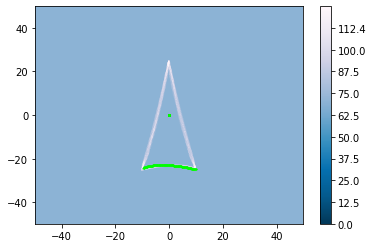

679.5935655999999  = Time taken for whole loop


In [81]:
# main loop
iterations = 20
walkersperiteration = int(len(route))
plotfrequency = 20 # number of plots you want (including final), make sure 'iterations' is divisible by this
plotevery = iterations/plotfrequency
stalledpos = []
walker_times = []
iteration_times = []
calc_tr_times = []
comparison_factor_array = []
stalledpos_stop_threshold = 1.1
endmainloop = 0
intensmaxvals = []
#convergence_threshold = ???

t11a = time.perf_counter()
for i in range(iterations):
        t11 = time.perf_counter()

        tpot_n_minus_1 = copy.deepcopy(TrailPotential)

        calc_tr_new() # original method

        #if __name__ == '__main__': # runs parallelised calc_tr
        #    with Pool(processes = multiprocessing.cpu_count()) as pool:
        #        starmapargs = [] # container for starmap arguments
        #        for xi in range(0,Nx): 
        #            for yi in range(0,Ny):
        #                starmapargs.append((xi,yi,TrailPotential,expdist,z,Weight,Nx,Ny))
        #        results3 = pool.starmap(mpf3.calc_tr, starmapargs)
        #        for pixel in list(results3):
        #            xitemp = pixel[0]
        #            yitemp = pixel[1]
        #            valuetemp = pixel[2]
        #            TrailPotential[xitemp,yitemp] = valuetemp

        #if __name__ == '__main__': # runs parallelised calc_tr
        #    with Pool(processes = multiprocessing.cpu_count()) as pool:
        #        starmapargs = [] # container for starmap arguments
        #        for xi in range(0,Nx):
        #                starmapargs.append((xi,TrailPotential,expdist,z,Weight,Nx,Ny))
        #        print('hello 1')
        #        results3 = pool.starmap(mpf3_2.calc_tr, starmapargs)
        #        print('hello 2')
        #        for row in list(results3):
        #            xitemp = row[0]
        #            valuetemp = row[1]
        #            TrailPotential[xitemp] = valuetemp

        #if __name__ == '__main__': # runs parallelised calc_tr
        #    with Pool(processes = multiprocessing.cpu_count()) as pool:
        #        starmapargs = [] # container for starmap arguments
        #        for core in range(1,multiprocessing.cpu_count()+1):
        #            starmapargs.append((core, TrailPotential, z, Weight, subexpdist)) # list of lists of args
        #        TrailPotential[:,:] = 0
        #        results = pool.starmap(mpf.calc_tr_new_mp, starmapargs)
        #        TrailPotential = np.concatenate(np.array(results[0:4]))
                #for ll in results:
                #    TrailPotential += np.array(ll)
                #Trailpotential = results
                #for core in results:

                #pool.close()
                #pool.join()

        tp_comparison_factor = np.mean(np.subtract(TrailPotential,tpot_n_minus_1))
        #if tp_comparison_factor > convergence_threshold: break
        print(tp_comparison_factor)
        comparison_factor_array.append(tp_comparison_factor)

        t22 = time.perf_counter()
        print(t22-t11,' = Time taken for calc_tr')
        calc_tr_times.append(t22-t11)

        intens[:]=0.
        stalledpos_tempcounter = 0

        if __name__ == '__main__': # runs parallelised set_up_walker
            with Pool(processes = multiprocessing.cpu_count()) as pool2:
                starmapargs2 = []
                for j in range(walkersperiteration):
                    #randomroute = np.random.randint(0,len(route))
                    #starmapargs2.append((randomroute, route, intens, xmin, xmax, ymin, ymax, Nx, Ny, x, y, TrailPotential)) #random route
                    starmapargs2.append((j, route, intens, xmin, xmax, ymin, ymax, Nx, Ny, x, y, TrailPotential))
                t11b = time.perf_counter()
                results2 = pool2.starmap(mpf7.set_up_walker_mp, starmapargs2)
                t22b = time.perf_counter()
                print(t22b-t11b,' = Time taken for iteration ', i,)
                iteration_times.append(t22b-t11b)
                for walker in list(results2):
                    print(i, walker[7], '|  Start: ', walker[0], 'Dest: ', walker[1], 'Pos: ', walker[2], 'Time of completion:', walker[8], 'Time taken: ', walker[9])
                    track = walker[3] # only keeping last walker's track data, for now

                    # experimental
                    if walker[7] == 'Reached Goal':
                        intens += walker[4] # summing intens from all walkers

                    #intens += walker[4] # summing intens from all walkers

                    grad = walker[6] # not sure if this should be last walker or sum of all NOTE: should probably be just the last one
                    walker_times.append(float(walker[9])) # collect times taken by walkers to go from A to B
                    # if there is a stall, append the coords to a list, count number of stalls in iteration
                    if len(walker[5]) != 0:
                        stalledpos.append(walker[5])
                        stalledpos_tempcounter +=1
                    # if number of stalls per iteration is too large, force stop main loop
                if stalledpos_tempcounter/walkersperiteration >= stalledpos_stop_threshold:
                    print('!!!!  Stopping early; number of stalls > threshold  !!!!')
                    endmainloop = 1

                finaliteration = i
                # collect relevant information from walkers
                
                intensmaxvals.append(np.max(intens)) # grab max value of intens, possibly for debugging/ sanity check

        t11c = time.perf_counter()
        update_ground()
        t22c = time.perf_counter()
        print(t22c-t11c,' = Time taken for update_ground ')
        #plot_path() 
        if (i+1) % plotevery == 0 and i != 0: plot_path()     
        #for j in range(0,walkersperiteration):
            #set_up_walker(np.random.randint(0,len(route))) # used if you want random routes
            #set_up_walker(j) # used if you want to run every route per potential calculation/ iteration
            #setup_potentials()
            #calc_path()
            #now = datetime.now() # referenced elsewhere
            #current_time = now.strftime("%H:%M:%S")
            #print(i, start," -> ", dest, pos,"      time = ", current_time)
        #update_ground()
        if endmainloop == 1: break
        #plot_path()
#print(str("Number of walkers = ")+str(numberofwalkers))
#print(str('Walker success rate = ')+str(successrate)+str(' %'))
#print('Average time taken for walker = '+str(np.mean(walker_times))+ ',    Min = '+str(min(walker_times))+',    Max = '+str(max(walker_times)))
#print('Average time taken for calc_tr = '+str(np.mean(calc_tr_times))+ ',    Min = '+str(min(calc_tr_times))+',    Max = '+str(max(calc_tr_times)))
t22a = time.perf_counter()
print(t22a-t11a, ' = Time taken for whole loop')

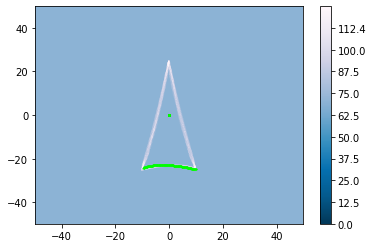

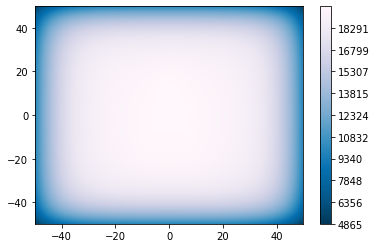

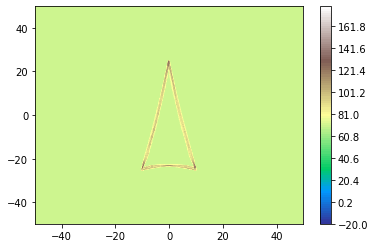

isigma =  0.15
trailpotweight =  0.0053*
trailpotweight (after stall) =  0.002*
t_track = 12.0
Number of walkers =  120
Number of iterations =  20
Walkers per iteration =  6
Walker success rate = 100.0 %
Average time taken per walker = 0.16508333333333333,    Min = 0.12,    Max = 0.21
Average time taken per iteration = 0.4759683199999699,    Min = 0.4525066000001061,    Max = 0.5207766000000902
Average time taken for calc_tr = 31.300517895000006,    Min = 31.006713399999853,    Max = 32.14934519999997
Time taken for whole loop =  679.5935655999999


In [82]:
# shortcut (ignore this comment, its for CTRL+F purposes)
plot_path()

cs = plt.contourf(X, Y, TrailPotential, levels=np.linspace(TrailPotential.min(),TrailPotential.max(),1000),cmap='PuBu_r')
cbar = plt.colorbar()

plt.show()

z_copy = copy.deepcopy(z)

#for i in range (len(z[0])):
#    for j in range (len(z)):
#        if z[i][j] >= 199:
#            z_copy[i][j] = 180
#        elif 150 <= z[i][j] < 199:
#            z_copy[i][j] = 90
#        else:
#            z_copy[i][j] = 0

def plot_path_threshold():
    plt.contourf(X, Y, z, levels=np.linspace(-20,180,100),cmap='terrain')
    plt.colorbar()
    #plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1)
    plt.show(block=False)

plot_path_threshold()

numberofwalkers = (finaliteration+1)*walkersperiteration
successrate = 100-(100*len(stalledpos))/numberofwalkers

print('isigma = ',isigma)
print('trailpotweight = ','0.0053*')
print('trailpotweight (after stall) = ','0.002*')
print('t_track =',t_track)

#print(str("Number of walkers = ")+str(finaliteration*walkersperiteration+stalledpos_stop_threshold*walkersperiteration))
print("Number of walkers = ",walkersperiteration*(finaliteration+1))
print("Number of iterations = ",finaliteration+1)
print('Walkers per iteration = ',walkersperiteration)



print(str('Walker success rate = ')+str(successrate)+str(' %'))
print('Average time taken per walker = '+str(np.mean(walker_times))+ ',    Min = '+str(min(walker_times))+',    Max = '+str(max(walker_times)))
print('Average time taken per iteration = '+str(np.mean(iteration_times))+ ',    Min = '+str(min(iteration_times))+',    Max = '+str(max(iteration_times)))
print('Average time taken for calc_tr = '+str(np.mean(calc_tr_times))+ ',    Min = '+str(min(calc_tr_times))+',    Max = '+str(max(calc_tr_times)))
print('Time taken for whole loop = ',t22a-t11a)

{'whiskers': [<matplotlib.lines.Line2D at 0x1ebdcba1160>,
 'caps': [<matplotlib.lines.Line2D at 0x1ebdcba1700>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ebde2a3d30>],
 'medians': [<matplotlib.lines.Line2D at 0x1ebdcba1ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ebdcba1f70>],
 'means': []}

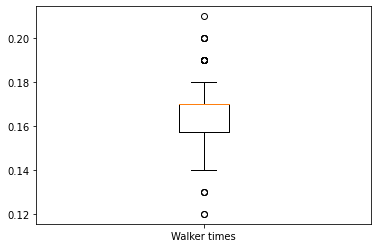

In [83]:
plt.boxplot([walker_times], labels=['Walker times'])


{'whiskers': [<matplotlib.lines.Line2D at 0x1ebde370940>,
 'caps': [<matplotlib.lines.Line2D at 0x1ebde370ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ebde34c4c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ebd8bd34c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ebd8bd3790>],
 'means': []}

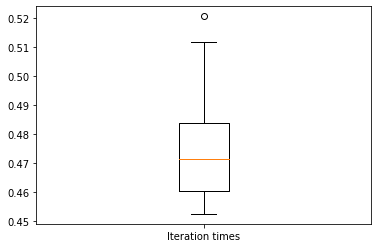

In [84]:
plt.boxplot([iteration_times], labels=["Iteration times"])

{'whiskers': [<matplotlib.lines.Line2D at 0x1ebde3f44c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ebde3f4a60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ebde3f4310>],
 'medians': [<matplotlib.lines.Line2D at 0x1ebde3f1040>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ebde3f1310>],
 'means': []}

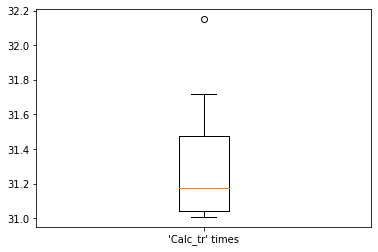

In [85]:
plt.boxplot([calc_tr_times], labels=["'Calc_tr' times"])

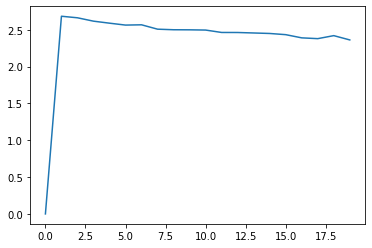

In [86]:
plt.plot(comparison_factor_array)

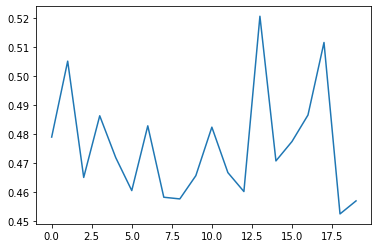

In [87]:
plt.plot(iteration_times)

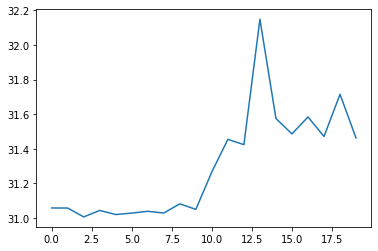

In [88]:
plt.plot(calc_tr_times)

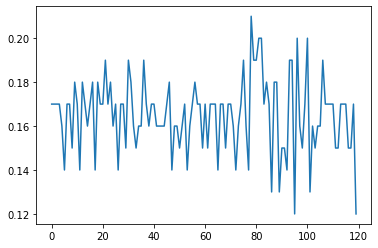

In [89]:
plt.plot(walker_times)

In [90]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],Base[i,j,0])

In [91]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],Base[i,j,0])

(array([200], dtype=int64), array([200], dtype=int64))


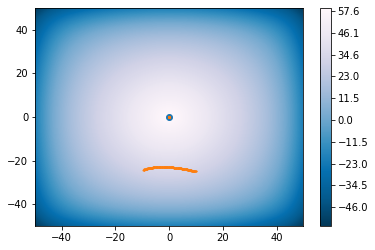

In [92]:
plot_potentials()

In [93]:
TrailPotential = sg.convolve2d(z*Weight,subexpdist[:,:],mode="same")
#print(TrailPotential)

[0. 0.]
[0. 0.]


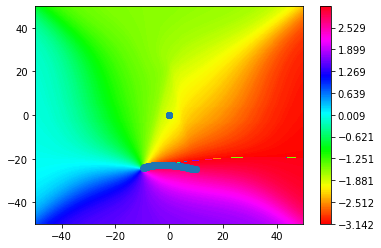

In [94]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

cbar = plt.colorbar()
plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])
#plt.scatter(start, dest)
print(start)
print(dest)
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

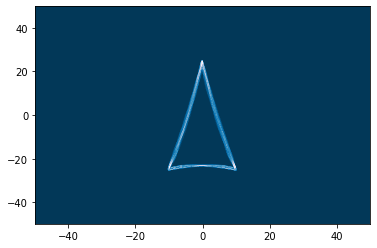

In [95]:
plot_path2()

In [ ]:
#Integrate z, trapezoid rule eq 20
# def calc_tr():
#    global xi,yi,TrailPotential,expdist,z,Weight,Nx,Ny
#    for xi in range(0,Nx): 
#        for yi in range(0,Ny):
#            TrailPotential[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*Weight[:,:])